In [ ]:
# 나눔고딕 폰트 설치 및 설정
!apt-get update -qq
!apt-get install fonts-nanum -qq
!fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
# 1. CropNet 패키지 설치 및 데이터 로드
!pip install cropnet datasets torch


In [6]:

import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# 폰트 설정
import matplotlib.font_manager as fm
# font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
# fontprop = fm.FontProperties(fname=font_path, size=10)
# plt.rcParams['font.family'] = 'NanumGothic'
# plt.rcParams['axes.unicode_minus'] = False

font_path='/System/Library/Fonts/AppleGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=10)
plt.rcParams['font.family'] = 'AppleGothic'  # macOS
plt.rcParams['axes.unicode_minus'] = False

/Users/kwangsiklee/miniforge3/envs/llmenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


| 컬럼명               | 설명                                       | 단위         | 의미/활용 예시                      |
| ----------------- | ---------------------------------------- | ---------- | ----------------------------- |
| **CO(GT)**        | **일산화탄소(CO) 농도 (Reference Analyzer 기준)** | mg/m³      | 실내·외 오염도 주요 지표, 차량/연료 연소에서 발생 |
| **PT08.S1(CO)**   | Tin Oxide 센서1 반응 (CO 측정용, PT08-S1)       | AR(analog) | CO 농도에 민감한 전기센서 출력            |
| **NMHC(GT)**      | 비메탄성 탄화수소(Non Methane HydroCarbons) 농도   | µg/m³      | 대기 오염, VOC 오염도 지표             |
| **C6H6(GT)**      | 벤젠(Benzene) 농도 (Reference Analyzer)      | µg/m³      | 발암성 오염물질, 대기질 평가 핵심           |
| **PT08.S2(NMHC)** | 센서2 반응 (NMHC 측정용, PT08-S2)               | AR(analog) | NMHC 농도에 민감                   |
| **NOx(GT)**       | 질소산화물(NOx) 농도 (Reference Analyzer)       | ppb        | 배기가스 오염, 오존 생성 관련             |
| **PT08.S3(NOx)**  | 센서3 반응 (NOx 측정용, PT08-S3)                | AR(analog) | NOx 농도에 민감                    |
| **NO2(GT)**       | 이산화질소(NO2) 농도 (Reference Analyzer)       | µg/m³      | 대기질 핵심(호흡기 질환 유발), 실측치        |
| **PT08.S4(NO2)**  | 센서4 반응 (NO2 측정용, PT08-S4)                | AR(analog) | NO2 농도에 민감                    |
| **PT08.S5(O3)**   | 센서5 반응 (O₃/CO 측정용, PT08-S5)              | AR(analog) | 오존/CO에 민감                     |
| **T**             | 온도(Temperature)                          | °C         | 대기질 센싱 환경 변수, 계절성 등           |
| **RH**            | 상대습도(Relative Humidity)                  | %          | 대기질 센싱 환경 변수, 센서 반응값에 영향      |
| **AH**            | 절대습도(Absolute Humidity)                  | g/m³       | 온도·습도 보정 및 대기 환경 변수           |


In [2]:
# 1. 데이터 다운로드 및 압축해제(파일명 명시)
import pandas as pd
import numpy as np
import requests
import io
import zipfile

# url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip"
# r = requests.get(url)

# with zipfile.ZipFile(io.BytesIO(r.content)) as z:
#     print("압축파일 내 파일 목록:", z.namelist())
#     with z.open('AirQualityUCI.csv') as f:
#         df = pd.read_csv(f, sep=';', decimal=',')

data_path = "./AirQualityUCI.csv"
df = pd.read_csv(data_path, sep=';', decimal=',')

print(df.shape)
# 마지막 행 결측치(빈행) 제거
df = df.iloc[:-1, :]

# 주요 변수만 추출 및 결측치 처리
cols = ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
        'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
        'PT08.S5(O3)', 'T', 'RH', 'AH']
df = df[cols].replace(-200, np.nan).astype(float)
df = df.fillna(method='ffill')   # 결측치는 앞 값으로 대체 (만약 오전 11시가 결측이면 10시데이터 사용)


(9471, 17)


/var/folders/xn/w4kqb1715fz7h49tp_h7hbmr0000gn/T/ipykernel_38907/2132856943.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')   # 결측치는 앞 값으로 대체 (만약 오전 11시가 결측이면 10시데이터 사용)


In [26]:

# 2. 시계열 데이터셋 생성 (과거 24시간 → 다음날 NO2 예측)
n_steps = 4
features = df.drop('NO2(GT)', axis=1).values
target = df['NO2(GT)'].values

X, y = [], []
for i in range(len(df)-n_steps):
    X.append(features[i:i+n_steps])
    y.append(target[i+n_steps])
X = np.array(X)
y = np.array(y)

# train/test 분할
from sklearn.model_selection import train_test_split

## 시간 데이터이기 때문에 시간순으로 학습 테스트,,, shuffle 하면 시간이 뒤집힐 수 있음
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


🌬️ 공기질 데이터 분포 분석
📊 데이터 기본 정보:
  - 데이터 크기: (9470, 13)
  - 분석 변수 개수: 13
  - 시간 범위: 9470시간 (약 394일)

🔍 결측치 현황:
  - CO(GT): 0개 (0.0%)
  - PT08.S1(CO): 0개 (0.0%)
  - NMHC(GT): 0개 (0.0%)
  - C6H6(GT): 0개 (0.0%)
  - PT08.S2(NMHC): 0개 (0.0%)
  - NOx(GT): 0개 (0.0%)
  - PT08.S3(NOx): 0개 (0.0%)
  - NO2(GT): 0개 (0.0%)
  - PT08.S4(NO2): 0개 (0.0%)
  - PT08.S5(O3): 0개 (0.0%)
  - T: 0개 (0.0%)
  - RH: 0개 (0.0%)
  - AH: 0개 (0.0%)

📈 기본 통계량:
        CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
count  9470.00      9470.00   9470.00   9470.00        9470.00  9470.00   
mean      2.08      1102.35    270.55     10.21         943.79   241.02   
std       1.46       218.30     72.87      7.52         268.21   205.40   
min       0.10       647.00      7.00      0.10         383.00     2.00   
25%       1.00       940.00    275.00      4.40         734.00    98.00   
50%       1.70      1065.00    275.00      8.40         915.00   176.00   
75%       2.70      1235.00    275.00     13.90 

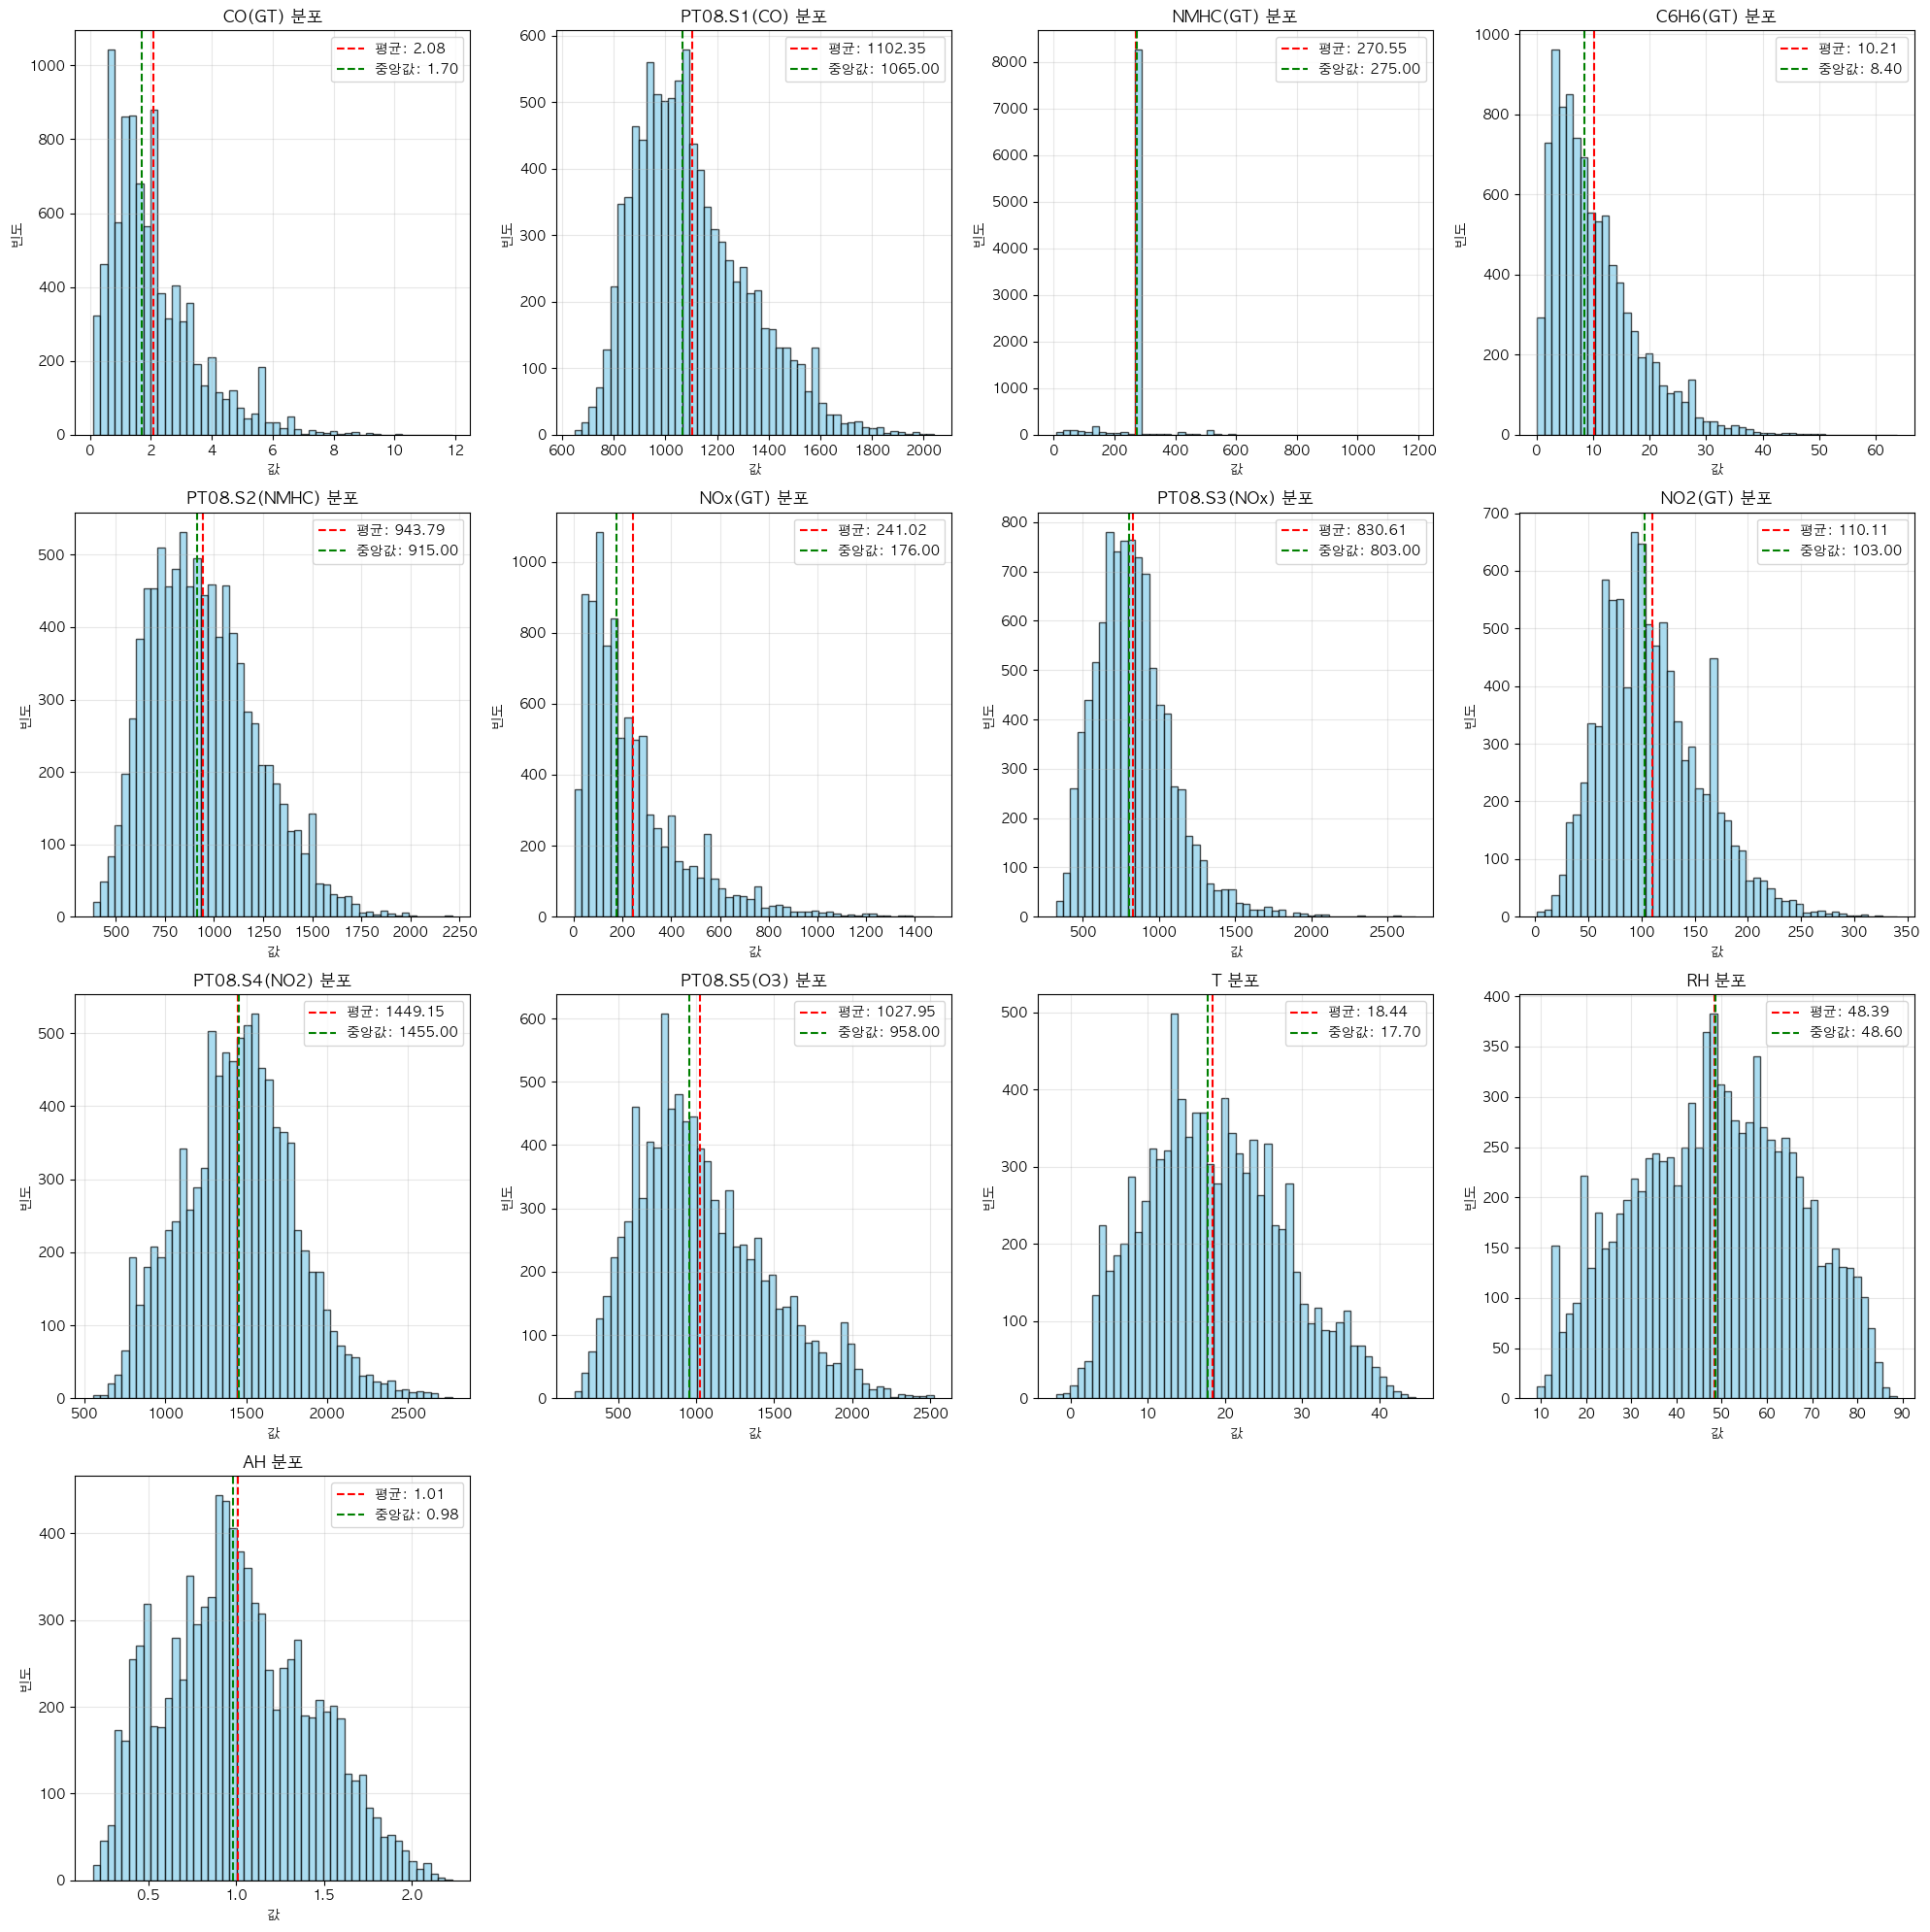

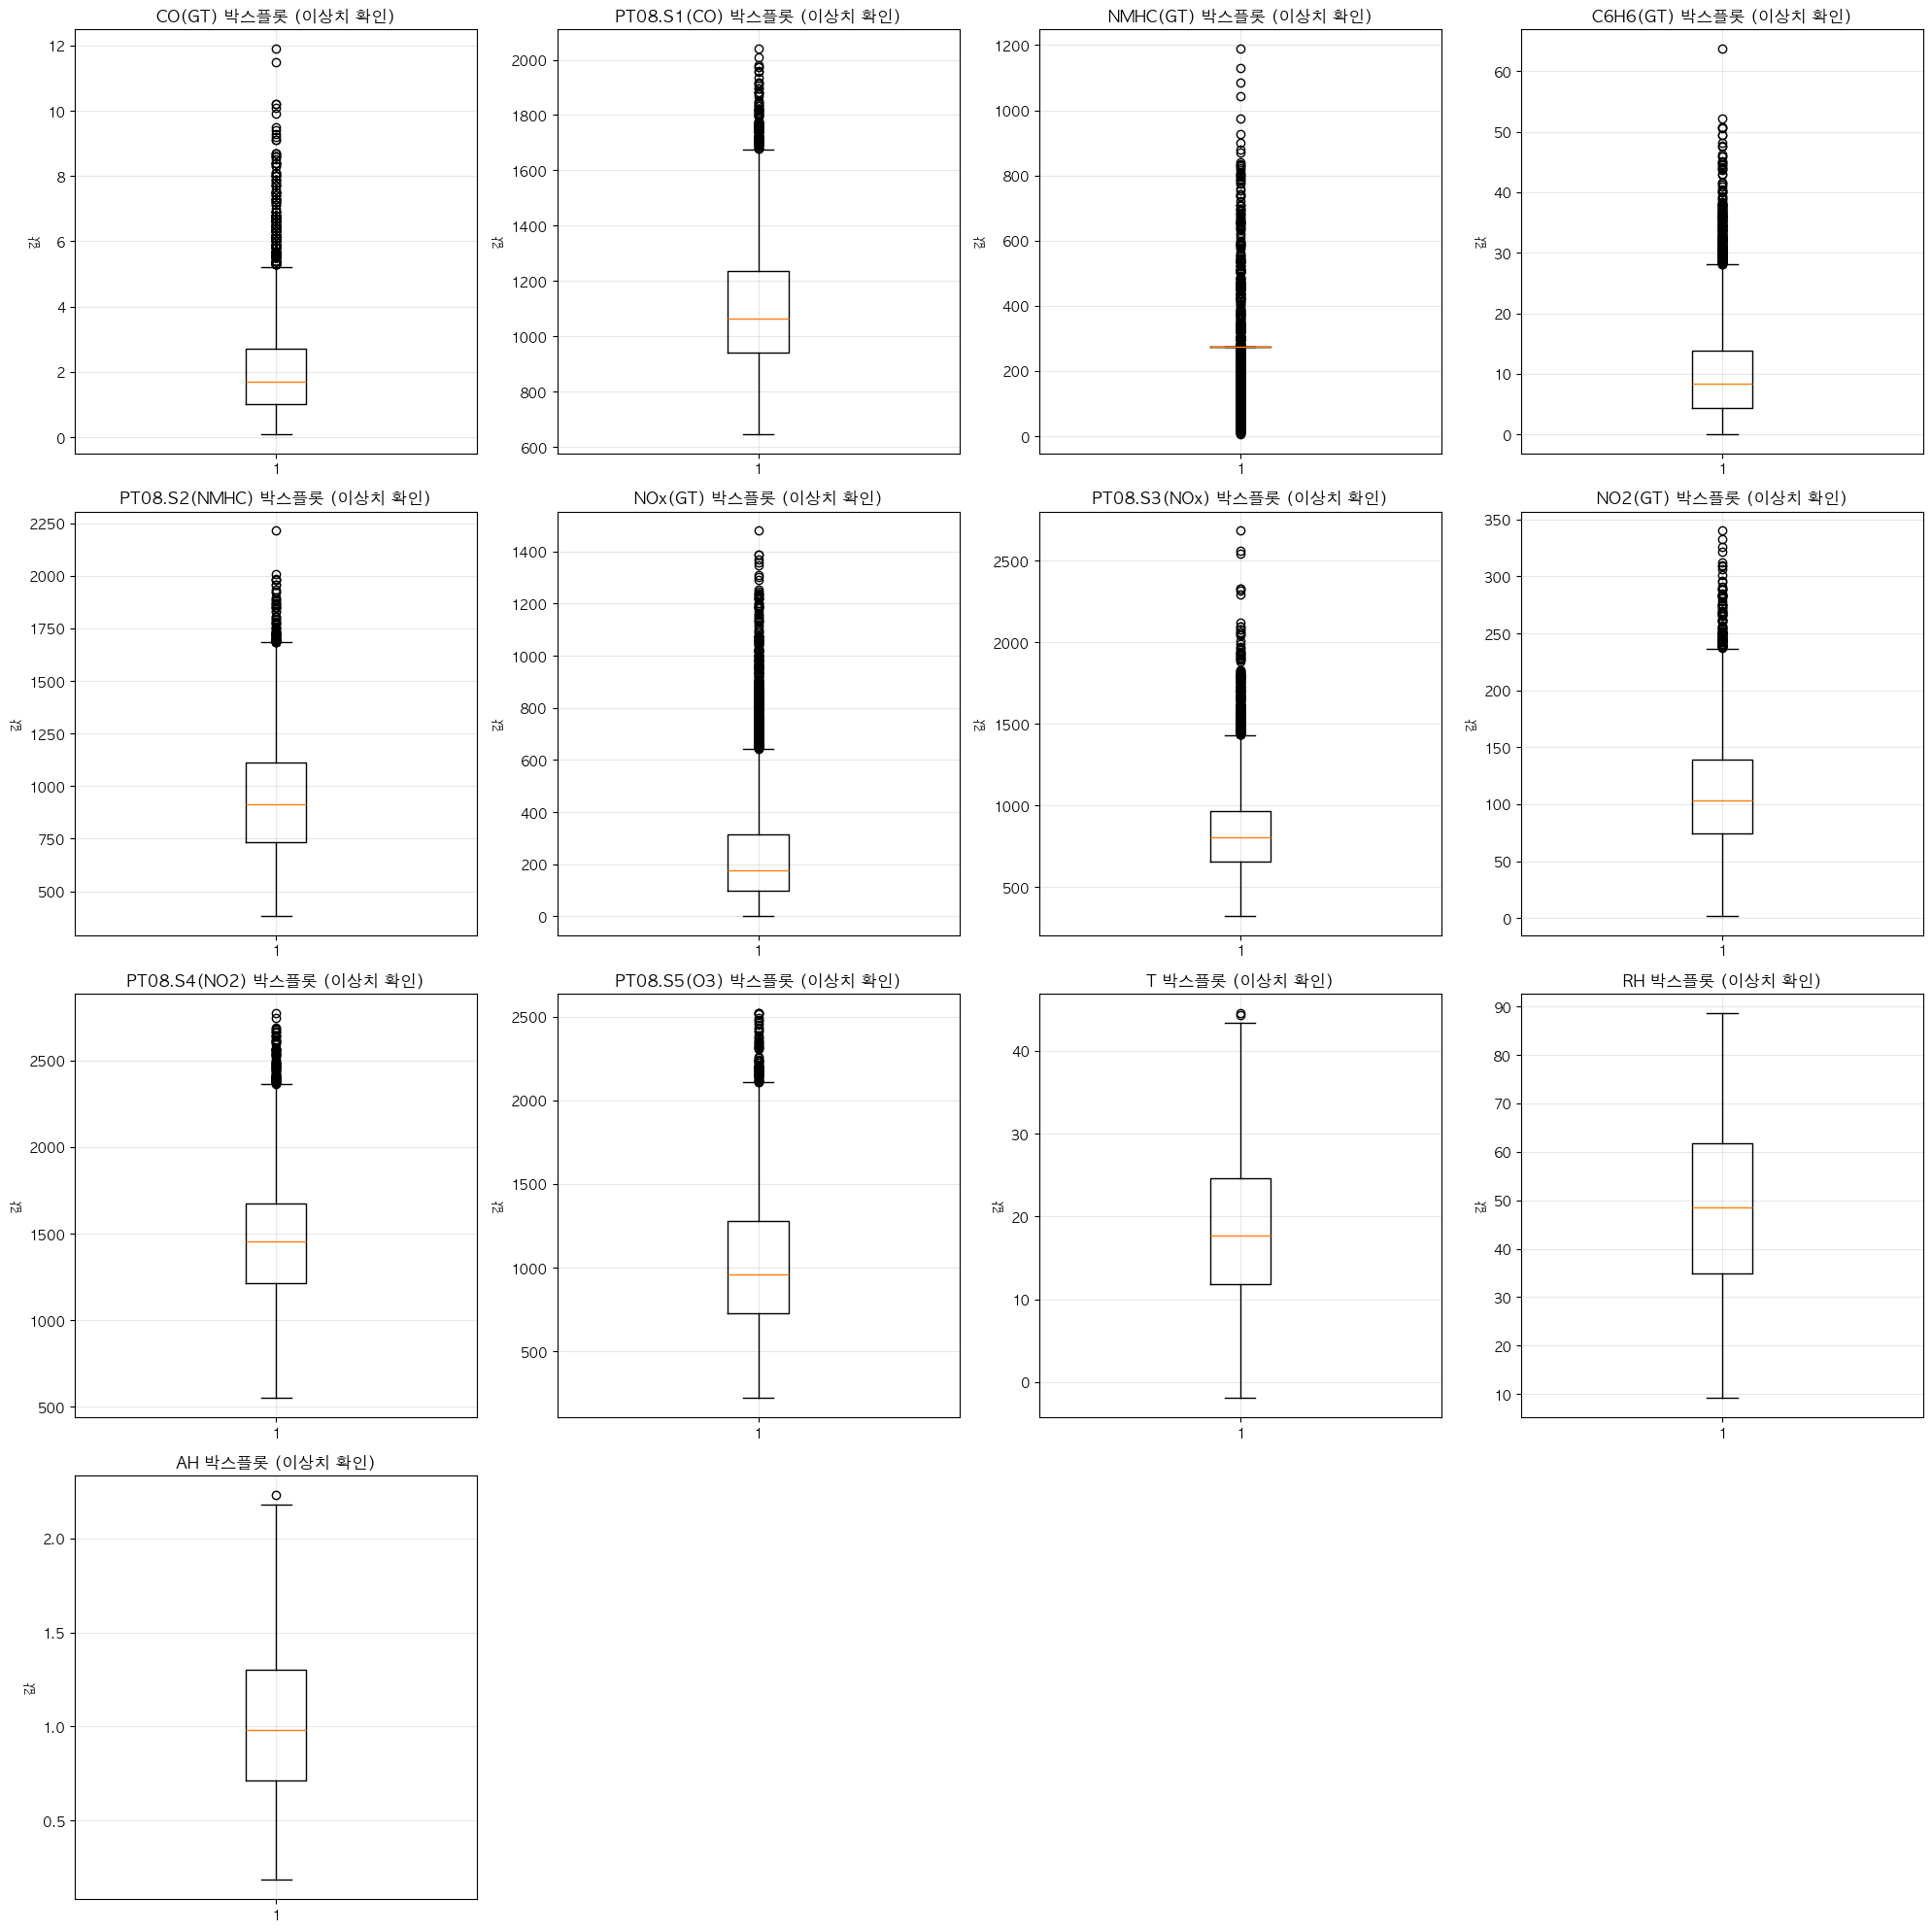

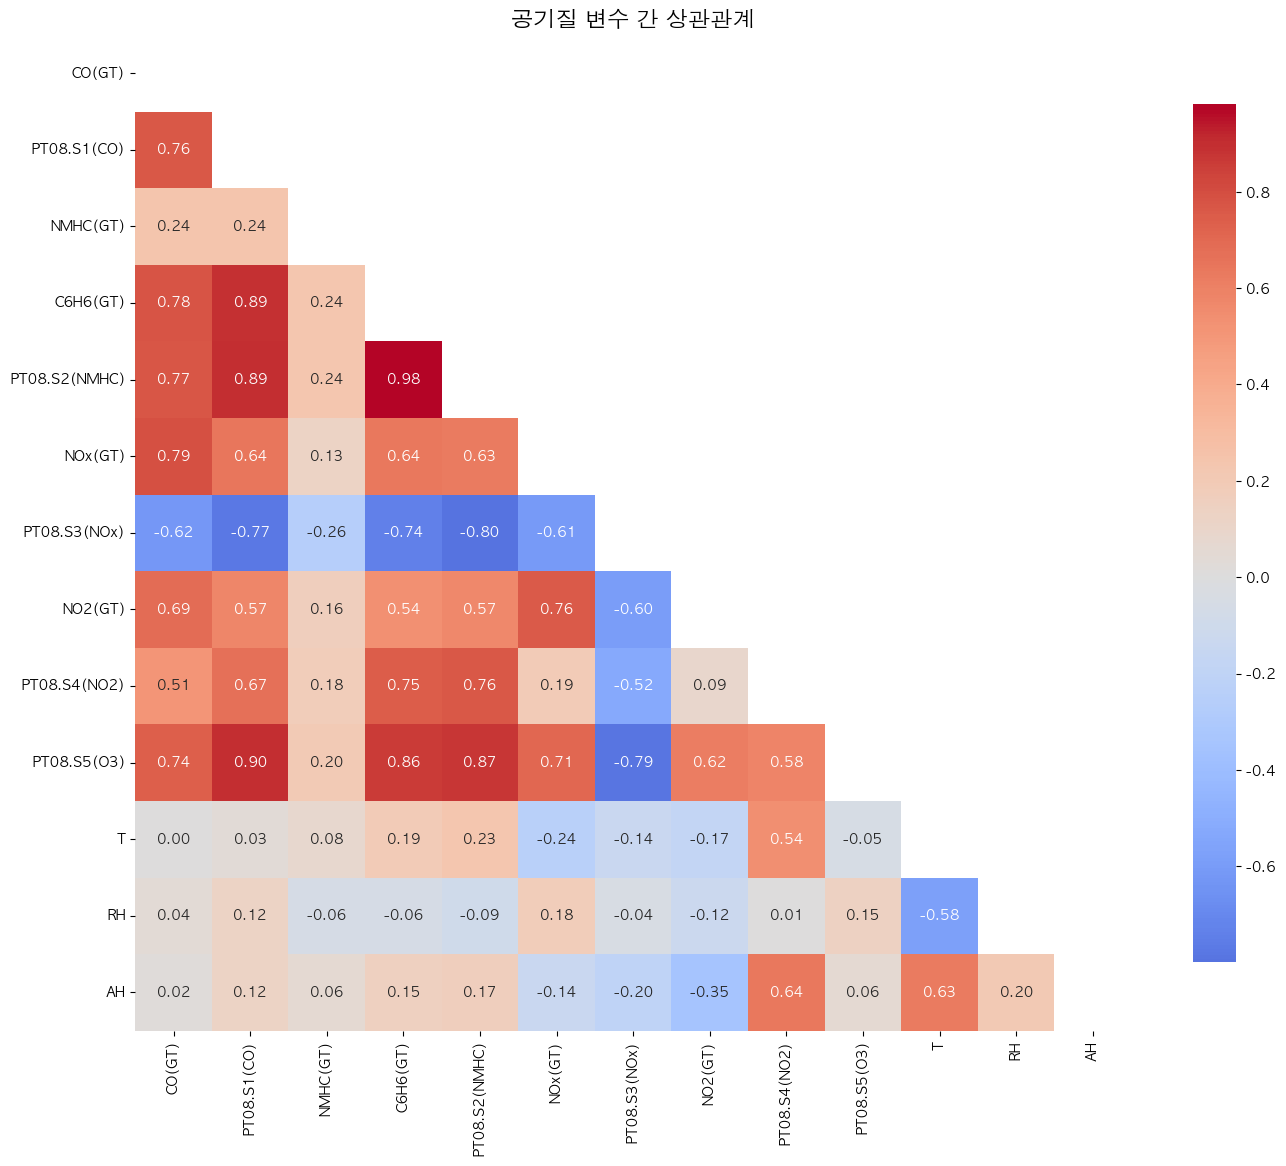


🔗 높은 상관관계를 보이는 변수 쌍들:
  - C6H6(GT) ↔ PT08.S2(NMHC): 0.982
  - PT08.S1(CO) ↔ PT08.S5(O3): 0.901
  - PT08.S1(CO) ↔ PT08.S2(NMHC): 0.894
  - PT08.S1(CO) ↔ C6H6(GT): 0.886
  - PT08.S2(NMHC) ↔ PT08.S5(O3): 0.872
  - C6H6(GT) ↔ PT08.S5(O3): 0.859
  - PT08.S2(NMHC) ↔ PT08.S3(NOx): -0.798
  - PT08.S3(NOx) ↔ PT08.S5(O3): -0.788
  - CO(GT) ↔ NOx(GT): 0.788
  - CO(GT) ↔ C6H6(GT): 0.779
  - PT08.S1(CO) ↔ PT08.S3(NOx): -0.774
  - CO(GT) ↔ PT08.S2(NMHC): 0.769
  - CO(GT) ↔ PT08.S1(CO): 0.763
  - PT08.S2(NMHC) ↔ PT08.S4(NO2): 0.761
  - NOx(GT) ↔ NO2(GT): 0.759
  - C6H6(GT) ↔ PT08.S4(NO2): 0.750
  - C6H6(GT) ↔ PT08.S3(NOx): -0.737
  - CO(GT) ↔ PT08.S5(O3): 0.735
  - NOx(GT) ↔ PT08.S5(O3): 0.707


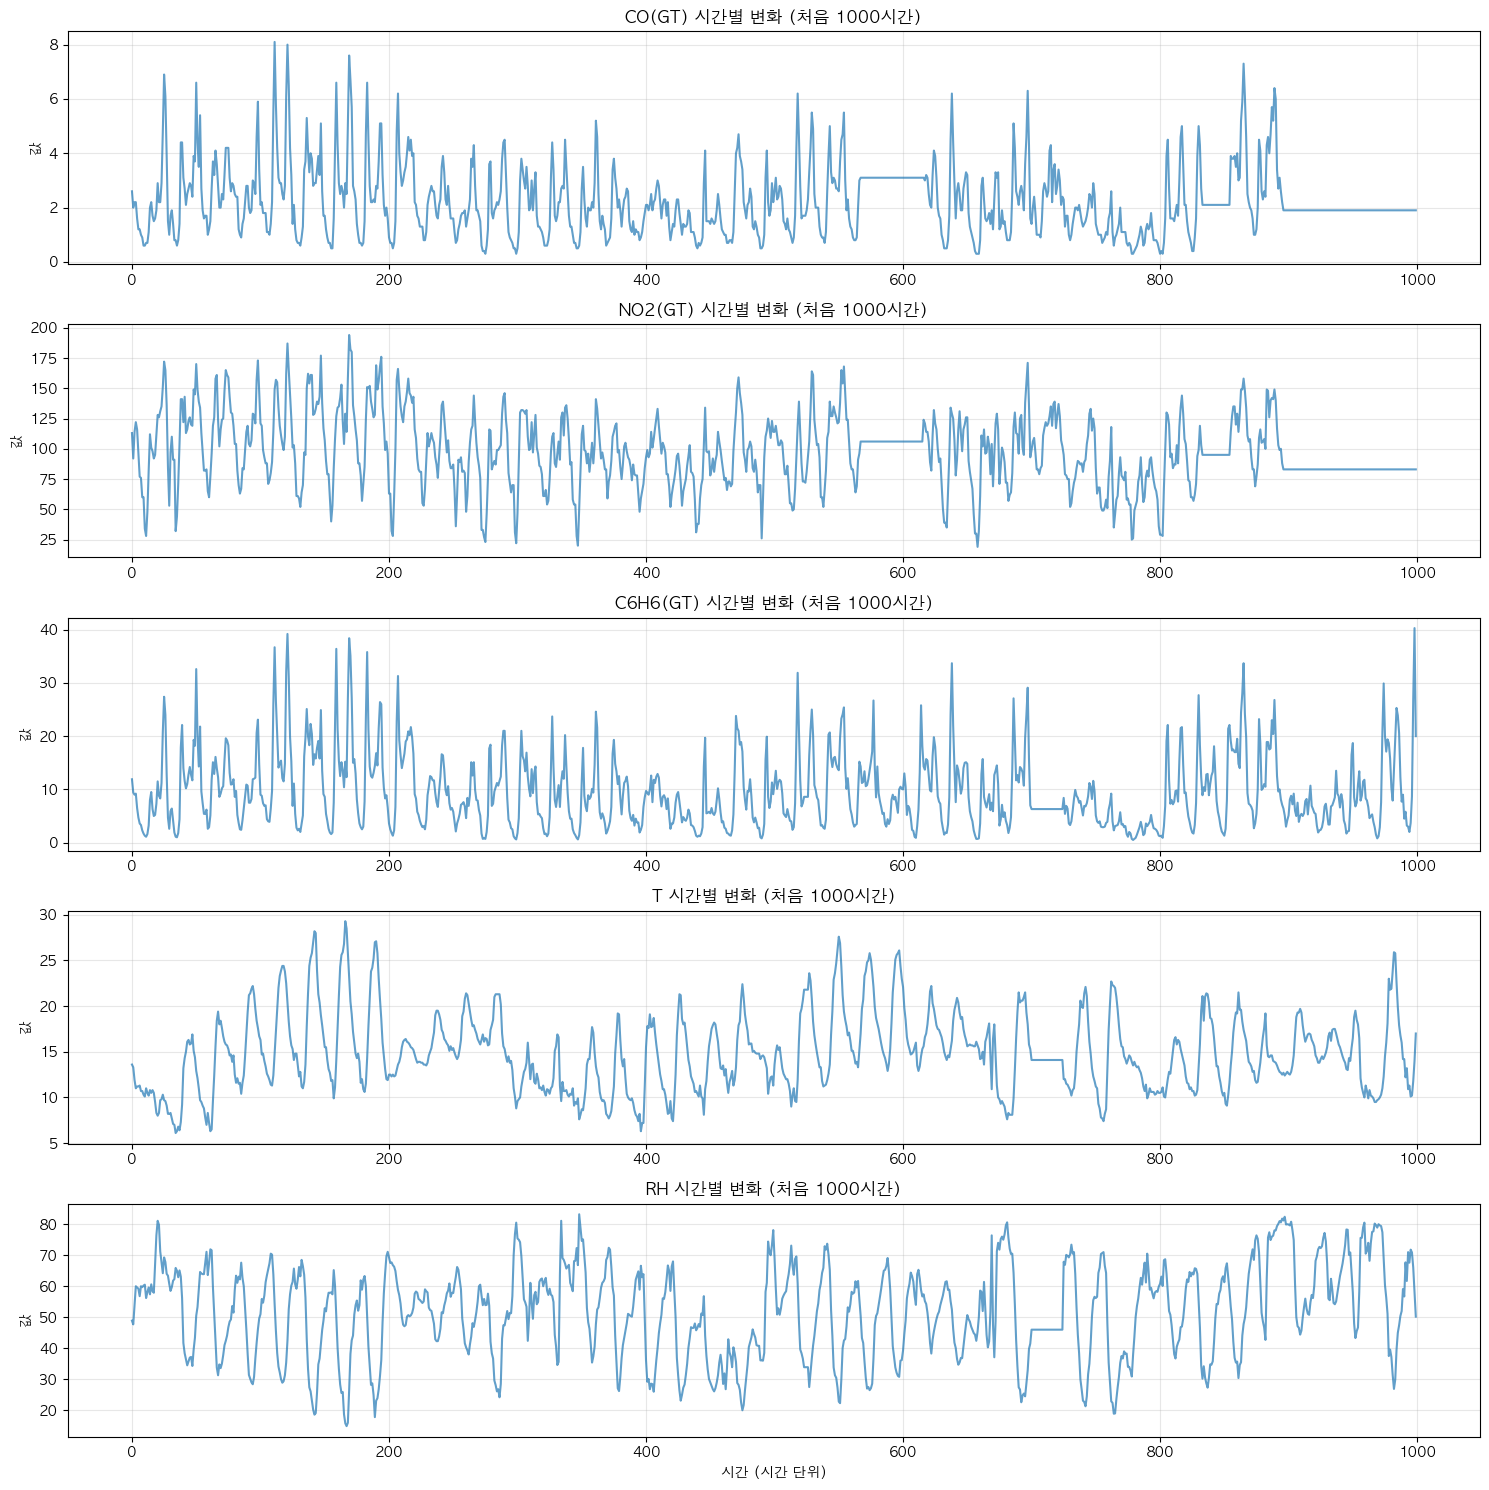


✅ 공기질 데이터 분포 분석 완료!


In [27]:
# 공기질 데이터 각 컬럼별 분포 분석
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

def analyze_air_quality_distribution(df, cols):
    """공기질 데이터의 각 컬럼별 분포를 분석하는 함수"""
    
    print("🌬️ 공기질 데이터 분포 분석")
    print("="*80)
    
    # 1. 기본 정보
    print(f"📊 데이터 기본 정보:")
    print(f"  - 데이터 크기: {df.shape}")
    print(f"  - 분석 변수 개수: {len(cols)}")
    print(f"  - 시간 범위: {len(df)}시간 (약 {len(df)//24:.0f}일)")
    print()
    
    # 2. 결측치 현황
    print("🔍 결측치 현황:")
    missing_info = df[cols].isnull().sum()
    for col in cols:
        missing_count = missing_info[col]
        missing_pct = (missing_count / len(df)) * 100
        print(f"  - {col}: {missing_count}개 ({missing_pct:.1f}%)")
    print()
    
    # 3. 기본 통계량
    print("📈 기본 통계량:")
    desc_stats = df[cols].describe()
    print(desc_stats.round(2))
    print()
    
    # 4. 각 변수별 상세 분석 및 시각화
    n_cols = 4
    n_rows = (len(cols) + n_cols - 1) // n_cols
    
    # 히스토그램 및 분포
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    print("🔬 변수별 상세 분석:")
    
    for i, col in enumerate(cols):
        data = df[col].dropna()
        
        # 통계 정보
        print(f"\n📊 {col}:")
        print(f"  - 평균: {data.mean():.3f}")
        print(f"  - 중앙값: {data.median():.3f}")
        print(f"  - 표준편차: {data.std():.3f}")
        print(f"  - 최솟값: {data.min():.3f}")
        print(f"  - 최댓값: {data.max():.3f}")
        print(f"  - 왜도(Skewness): {data.skew():.3f}")
        print(f"  - 첨도(Kurtosis): {data.kurtosis():.3f}")
        
        # 이상치 분석
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        outliers = data[(data < Q1 - 1.5*IQR) | (data > Q3 + 1.5*IQR)]
        print(f"  - 이상치 개수: {len(outliers)}개 ({len(outliers)/len(data)*100:.1f}%)")
        
        # 정규성 검정 (샘플 크기가 클 경우 샘플링)
        if len(data) > 5000:
            sample_data = data.sample(5000, random_state=42)
        else:
            sample_data = data
            
        try:
            stat, p_value = stats.shapiro(sample_data)
            is_normal = "Yes" if p_value > 0.05 else "No"
            print(f"  - 정규분포 여부: {is_normal} (p-value: {p_value:.4f})")
        except:
            print(f"  - 정규분포 여부: 검정 불가")
        
        # 히스토그램 그리기
        if i < len(axes):
            axes[i].hist(data, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
            axes[i].axvline(data.mean(), color='red', linestyle='--', label=f'평균: {data.mean():.2f}')
            axes[i].axvline(data.median(), color='green', linestyle='--', label=f'중앙값: {data.median():.2f}')
            axes[i].set_title(f'{col} 분포')
            axes[i].set_xlabel('값')
            axes[i].set_ylabel('빈도')
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
    
    # 빈 subplot 제거
    for j in range(len(cols), len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()
    
    # 5. 박스플롯으로 이상치 시각화
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    for i, col in enumerate(cols):
        if i < len(axes):
            data = df[col].dropna()
            axes[i].boxplot(data)
            axes[i].set_title(f'{col} 박스플롯 (이상치 확인)')
            axes[i].set_ylabel('값')
            axes[i].grid(True, alpha=0.3)
    
    # 빈 subplot 제거
    for j in range(len(cols), len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()
    
    # 6. 상관관계 히트맵
    plt.figure(figsize=(14, 12))
    correlation_matrix = df[cols].corr()
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', 
                center=0, square=True, fmt='.2f', cbar_kws={"shrink": .8})
    plt.title('공기질 변수 간 상관관계', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # 7. 높은 상관관계 변수 쌍 찾기
    print("\n🔗 높은 상관관계를 보이는 변수 쌍들:")
    corr_pairs = []
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            corr_val = correlation_matrix.iloc[i, j]
            if abs(corr_val) > 0.7:  # 상관계수 절댓값이 0.7 이상
                corr_pairs.append((cols[i], cols[j], corr_val))
    
    corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
    
    if corr_pairs:
        for var1, var2, corr in corr_pairs:
            print(f"  - {var1} ↔ {var2}: {corr:.3f}")
    else:
        print("  - 상관계수 0.7 이상인 변수 쌍 없음")
    
    # 8. 시간에 따른 변화 패턴 (일부 주요 변수만)
    key_vars = ['CO(GT)', 'NO2(GT)', 'C6H6(GT)', 'T', 'RH']  # 주요 변수들
    available_vars = [var for var in key_vars if var in cols]
    
    if available_vars:
        fig, axes = plt.subplots(len(available_vars), 1, figsize=(15, 3*len(available_vars)))
        if len(available_vars) == 1:
            axes = [axes]
        
        for i, var in enumerate(available_vars):
            # 처음 1000개 데이터포인트만 표시 (너무 많으면 시각화가 복잡함)
            data_slice = df[var].iloc[:1000]
            axes[i].plot(data_slice, alpha=0.7)
            axes[i].set_title(f'{var} 시간별 변화 (처음 1000시간)')
            axes[i].set_ylabel('값')
            axes[i].grid(True, alpha=0.3)
        
        axes[-1].set_xlabel('시간 (시간 단위)')
        plt.tight_layout()
        plt.show()
    
    print("\n" + "="*80)
    print("✅ 공기질 데이터 분포 분석 완료!")
    
    return df

# 함수 실행
cols = ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
        'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
        'PT08.S5(O3)', 'T', 'RH', 'AH']

analyzed_df = analyze_air_quality_distribution(df, cols)

📊 정규화 전 데이터 통계:
Features 통계:
  - 평균: [2.08360084e+00 1.10235174e+03 2.70550475e+02 1.02107920e+01
 9.43794615e+02 2.41020803e+02 8.30609398e+02 1.44914826e+03
 1.02795227e+03 1.84388596e+01 4.83912355e+01 1.01124135e+00]
  - 표준편차: [1.46098371e+00 2.18289588e+02 7.28659235e+01 7.52238572e+00
 2.68193761e+02 2.05387955e+02 2.54905576e+02 3.47124056e+02
 4.09099567e+02 8.83805513e+00 1.76801602e+01 4.06245580e-01]
  - 최솟값: [ 1.000e-01  6.470e+02  7.000e+00  1.000e-01  3.830e+02  2.000e+00
  3.220e+02  5.510e+02  2.210e+02 -1.900e+00  9.200e+00  1.847e-01]
  - 최댓값: [1.190e+01 2.040e+03 1.189e+03 6.370e+01 2.214e+03 1.479e+03 2.683e+03
 2.775e+03 2.523e+03 4.460e+01 8.870e+01 2.231e+00]

Target(NO2) 통계:
  - 평균: 110.114
  - 표준편차: 47.366
  - 최솟값: 2.000
  - 최댓값: 340.000

🔄 다양한 정규화 방법으로 데이터 생성
📏 StandardScaler 결과:
  - X_train shape: (7572, 4, 12)
  - X_test shape: (1894, 4, 12)
  - y_train 통계: 평균=-0.000, 표준편차=1.000
  - y_test 통계: 평균=1.032, 표준편차=1.259

📐 MinMaxScaler 결과:
  - X_train shape: (7572

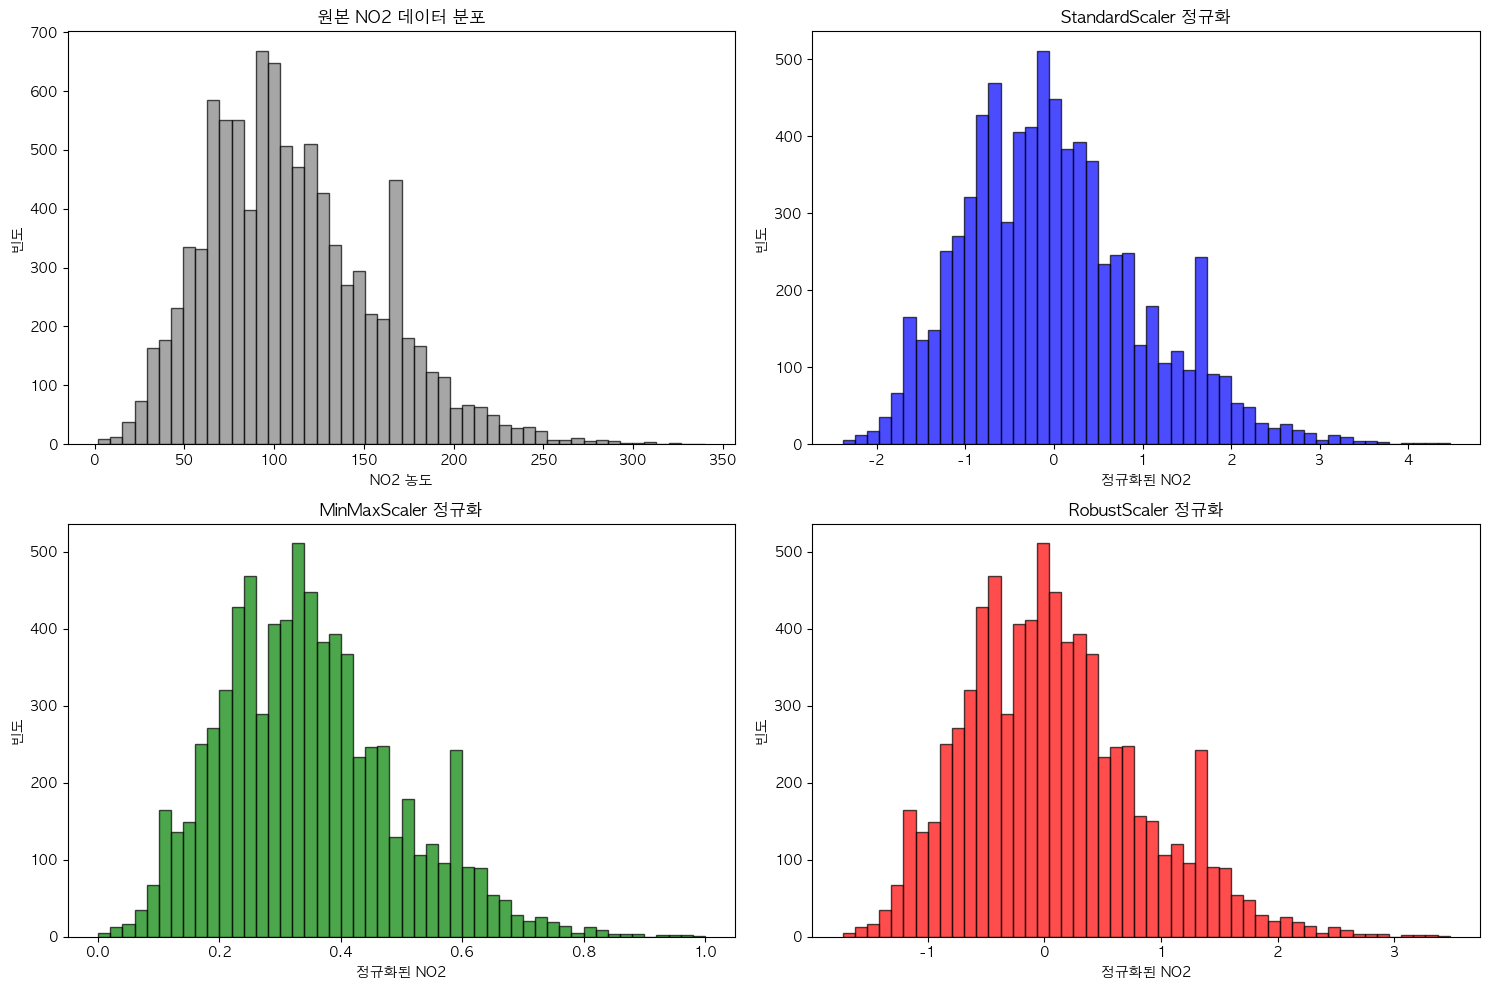


✅ 기본 정규화 설정: StandardScaler
   - 최종 학습 데이터: (7572, 4, 12)
   - 최종 테스트 데이터: (1894, 4, 12)


In [28]:
# 데이터 정규화 추가
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import numpy as np

print("📊 정규화 전 데이터 통계:")
print("Features 통계:")
print(f"  - 평균: {features.mean(axis=0)}")
print(f"  - 표준편차: {features.std(axis=0)}")
print(f"  - 최솟값: {features.min(axis=0)}")
print(f"  - 최댓값: {features.max(axis=0)}")
print(f"\nTarget(NO2) 통계:")
print(f"  - 평균: {target.mean():.3f}")
print(f"  - 표준편차: {target.std():.3f}")
print(f"  - 최솟값: {target.min():.3f}")
print(f"  - 최댓값: {target.max():.3f}")

# 1. StandardScaler (평균 0, 표준편차 1로 정규화)
def create_normalized_sequences_standard(features, target, n_steps):
    """StandardScaler를 사용한 정규화 및 시퀀스 생성"""
    
    # 원본 데이터를 시간 순서대로 train/test 분할 (80:20)
    split_idx = int(len(features) * 0.8)
    
    # Train 데이터로 scaler 학습
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()
    
    # Features 정규화
    features_train = features[:split_idx]
    features_test = features[split_idx:]
    
    feature_scaler.fit(features_train)
    features_scaled = feature_scaler.transform(features)
    
    # Target 정규화
    target_train = target[:split_idx].reshape(-1, 1)
    target_test = target[split_idx:].reshape(-1, 1)
    
    target_scaler.fit(target_train)
    target_scaled = target_scaler.transform(target.reshape(-1, 1)).flatten()
    
    # 시퀀스 생성
    X, y = [], []
    for i in range(len(features_scaled) - n_steps):
        X.append(features_scaled[i:i+n_steps])
        y.append(target_scaled[i+n_steps])
    
    X = np.array(X)
    y = np.array(y)
    
    # Train/test 분할 (시간 순서 유지)
    train_size = split_idx - n_steps
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    return X_train, X_test, y_train, y_test, feature_scaler, target_scaler

# 2. MinMaxScaler (0~1 범위로 정규화)
def create_normalized_sequences_minmax(features, target, n_steps):
    """MinMaxScaler를 사용한 정규화 및 시퀀스 생성"""
    
    split_idx = int(len(features) * 0.8)
    
    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()
    
    # Train 데이터로 scaler 학습
    features_train = features[:split_idx]
    target_train = target[:split_idx].reshape(-1, 1)
    
    feature_scaler.fit(features_train)
    target_scaler.fit(target_train)
    
    # 전체 데이터 정규화
    features_scaled = feature_scaler.transform(features)
    target_scaled = target_scaler.transform(target.reshape(-1, 1)).flatten()
    
    # 시퀀스 생성
    X, y = [], []
    for i in range(len(features_scaled) - n_steps):
        X.append(features_scaled[i:i+n_steps])
        y.append(target_scaled[i+n_steps])
    
    X = np.array(X)
    y = np.array(y)
    
    # Train/test 분할
    train_size = split_idx - n_steps
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    return X_train, X_test, y_train, y_test, feature_scaler, target_scaler

# 3. RobustScaler (중앙값과 IQR 사용, 이상치에 강함)
def create_normalized_sequences_robust(features, target, n_steps):
    """RobustScaler를 사용한 정규화 및 시퀀스 생성"""
    
    split_idx = int(len(features) * 0.8)
    
    feature_scaler = RobustScaler()
    target_scaler = RobustScaler()
    
    # Train 데이터로 scaler 학습
    features_train = features[:split_idx]
    target_train = target[:split_idx].reshape(-1, 1)
    
    feature_scaler.fit(features_train)
    target_scaler.fit(target_train)
    
    # 전체 데이터 정규화
    features_scaled = feature_scaler.transform(features)
    target_scaled = target_scaler.transform(target.reshape(-1, 1)).flatten()
    
    # 시퀀스 생성
    X, y = [], []
    for i in range(len(features_scaled) - n_steps):
        X.append(features_scaled[i:i+n_steps])
        y.append(target_scaled[i+n_steps])
    
    X = np.array(X)
    y = np.array(y)
    
    # Train/test 분할
    train_size = split_idx - n_steps
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    return X_train, X_test, y_train, y_test, feature_scaler, target_scaler

# 4. 정규화 방법별 비교
print("\n" + "="*80)
print("🔄 다양한 정규화 방법으로 데이터 생성")
print("="*80)

# StandardScaler 적용
X_train_std, X_test_std, y_train_std, y_test_std, feat_scaler_std, target_scaler_std = \
    create_normalized_sequences_standard(features, target, n_steps)

print(f"📏 StandardScaler 결과:")
print(f"  - X_train shape: {X_train_std.shape}")
print(f"  - X_test shape: {X_test_std.shape}")
print(f"  - y_train 통계: 평균={y_train_std.mean():.3f}, 표준편차={y_train_std.std():.3f}")
print(f"  - y_test 통계: 평균={y_test_std.mean():.3f}, 표준편차={y_test_std.std():.3f}")

# MinMaxScaler 적용
X_train_mm, X_test_mm, y_train_mm, y_test_mm, feat_scaler_mm, target_scaler_mm = \
    create_normalized_sequences_minmax(features, target, n_steps)

print(f"\n📐 MinMaxScaler 결과:")
print(f"  - X_train shape: {X_train_mm.shape}")
print(f"  - X_test shape: {X_test_mm.shape}")
print(f"  - y_train 범위: [{y_train_mm.min():.3f}, {y_train_mm.max():.3f}]")
print(f"  - y_test 범위: [{y_test_mm.min():.3f}, {y_test_mm.max():.3f}]")

# RobustScaler 적용
X_train_rb, X_test_rb, y_train_rb, y_test_rb, feat_scaler_rb, target_scaler_rb = \
    create_normalized_sequences_robust(features, target, n_steps)

print(f"\n📊 RobustScaler 결과:")
print(f"  - X_train shape: {X_train_rb.shape}")
print(f"  - X_test shape: {X_test_rb.shape}")
print(f"  - y_train 통계: 평균={y_train_rb.mean():.3f}, 표준편차={y_train_rb.std():.3f}")
print(f"  - y_test 통계: 평균={y_test_rb.mean():.3f}, 표준편차={y_test_rb.std():.3f}")

# 5. 정규화 효과 시각화
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 원본 데이터
axes[0, 0].hist(target, bins=50, alpha=0.7, color='gray', edgecolor='black')
axes[0, 0].set_title('원본 NO2 데이터 분포')
axes[0, 0].set_xlabel('NO2 농도')
axes[0, 0].set_ylabel('빈도')

# StandardScaler
axes[0, 1].hist(y_train_std, bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0, 1].set_title('StandardScaler 정규화')
axes[0, 1].set_xlabel('정규화된 NO2')
axes[0, 1].set_ylabel('빈도')

# MinMaxScaler
axes[1, 0].hist(y_train_mm, bins=50, alpha=0.7, color='green', edgecolor='black')
axes[1, 0].set_title('MinMaxScaler 정규화')
axes[1, 0].set_xlabel('정규화된 NO2')
axes[1, 0].set_ylabel('빈도')

# RobustScaler
axes[1, 1].hist(y_train_rb, bins=50, alpha=0.7, color='red', edgecolor='black')
axes[1, 1].set_title('RobustScaler 정규화')
axes[1, 1].set_xlabel('정규화된 NO2')
axes[1, 1].set_ylabel('빈도')

plt.tight_layout()
plt.show()

# 6. 역정규화 함수 정의
def inverse_transform_predictions(predictions, scaler):
    """예측값을 원래 스케일로 되돌리는 함수"""
    return scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

# 기본값으로 StandardScaler 사용 (일반적으로 가장 많이 사용됨)
X_train, X_test, y_train, y_test = X_train_std, X_test_std, y_train_std, y_test_std
feature_scaler, target_scaler = feat_scaler_std, target_scaler_std

print(f"\n✅ 기본 정규화 설정: StandardScaler")
print(f"   - 최종 학습 데이터: {X_train.shape}")
print(f"   - 최종 테스트 데이터: {X_test.shape}")

입력 데이터 형태: (9466, 4, 12)

=== 모델 비교 ===
기존 모델 파라미터 수: 20,033
개선 모델 파라미터 수: 150,146

=== 모델 학습 시작 ===
Epoch   1: Train=0.4259, Val=1.0003, LR=0.001000
Epoch  10: Train=0.2507, Val=0.7855, LR=0.001000
Epoch  20: Train=0.2079, Val=0.7876, LR=0.001000
Epoch  30: Train=0.1759, Val=0.7773, LR=0.000250
Early stopping at epoch 33

=== 개선된 모델 성능 (정규화 해제 후) ===
MSE: 1073.9199
MAE: 23.7574
R2 Score: 0.6111
RMSE: 32.7707


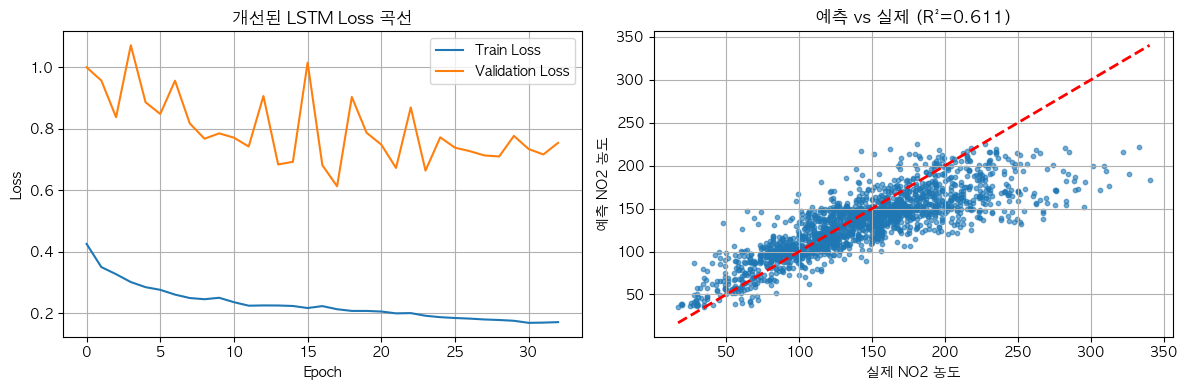

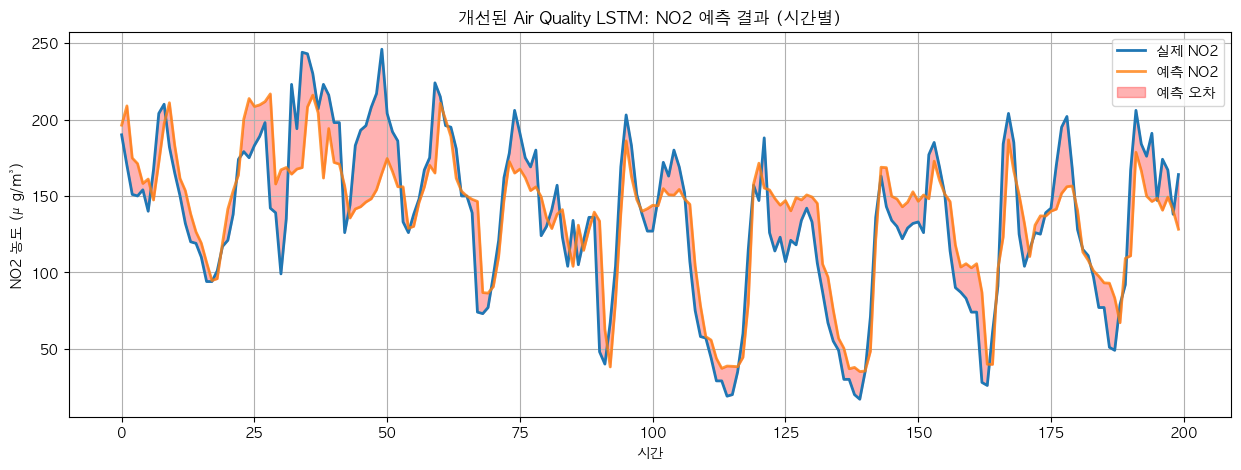


✅ 개선된 모델 완성!
   - 양방향 LSTM 사용
   - 어텐션 메커니즘 적용
   - 드롭아웃 및 배치 정규화 추가
   - 다층 FC 네트워크
   - Early Stopping 및 학습률 스케줄링


In [29]:
# PyTorch Dataset
import torch
from torch.utils.data import Dataset, DataLoader

class AirQualitySeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1,1)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = AirQualitySeqDataset(X_train, y_train)
test_ds = AirQualitySeqDataset(X_test, y_test)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

# 3. 개선된 LSTM 모델 정의
import torch.nn as nn
import torch.nn.functional as F

class ImprovedAirLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.3):
        super().__init__()
        
        # 양방향 LSTM으로 개선
        self.lstm = nn.LSTM(
            input_size, 
            hidden_size, 
            num_layers, 
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True  # 양방향 LSTM
        )
        
        # 양방향이므로 hidden_size * 2
        lstm_output_size = hidden_size * 2
        
        # Dropout 레이어 추가
        self.dropout1 = nn.Dropout(dropout)
        
        # 배치 정규화 추가
        self.batch_norm1 = nn.BatchNorm1d(lstm_output_size)
        
        # 다층 FC 네트워크
        self.fc1 = nn.Linear(lstm_output_size, hidden_size)
        self.dropout2 = nn.Dropout(dropout * 0.5)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)
        
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.dropout3 = nn.Dropout(dropout * 0.3)
        
        self.fc_out = nn.Linear(hidden_size // 2, 1)
        
        # 어텐션 메커니즘 (간단한 버전)
        self.attention = nn.Linear(lstm_output_size, 1)
        
    def forward(self, x):
        # LSTM 출력
        lstm_out, _ = self.lstm(x)  # (batch, seq_len, hidden_size*2)
        
        # 어텐션 메커니즘 적용
        attention_weights = torch.softmax(self.attention(lstm_out), dim=1)
        attended_output = torch.sum(lstm_out * attention_weights, dim=1)
        
        # Dropout 및 배치 정규화
        x = self.dropout1(attended_output)
        x = self.batch_norm1(x)
        
        # 첫 번째 FC 레이어
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.batch_norm2(x)
        
        # 두 번째 FC 레이어
        x = F.relu(self.fc2(x))
        x = self.dropout3(x)
        
        # 출력 레이어
        output = self.fc_out(x)
        
        return output

# 기존 모델도 유지 (비교용)
class AirLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:,-1,:]
        out = self.fc(out)
        return out

print(f"입력 데이터 형태: {X.shape}")

# 개선된 모델과 기존 모델 비교
print("\n=== 모델 비교 ===")
original_model = AirLSTM(input_size=X.shape[2])
improved_model = ImprovedAirLSTM(input_size=X.shape[2])

print(f"기존 모델 파라미터 수: {sum(p.numel() for p in original_model.parameters()):,}")
print(f"개선 모델 파라미터 수: {sum(p.numel() for p in improved_model.parameters()):,}")

# 개선된 모델로 학습
model = improved_model
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
criterion = nn.MSELoss()

# 4. 학습 (Early Stopping 추가)
losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0
epochs = 100
patience = 15

print("\n=== 모델 학습 시작 ===")
for epoch in range(epochs):
    # 학습 모드
    model.train()
    epoch_loss = 0
    for xb, yb in train_loader:
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()
        epoch_loss += loss.item()
    
    # 검증 모드
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            pred = model(xb)
            loss = criterion(pred, yb)
            val_loss += loss.item()
    
    train_loss = epoch_loss / len(train_loader)
    val_loss = val_loss / len(test_loader)
    
    losses.append(train_loss)
    val_losses.append(val_loss)
    
    # 학습률 스케줄러 업데이트
    scheduler.step(val_loss)
    
    # Early stopping 체크
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # 최고 모델 저장
        torch.save(model.state_dict(), 'best_air_lstm_model.pth')
    else:
        patience_counter += 1
    
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}: Train={train_loss:.4f}, Val={val_loss:.4f}, LR={optimizer.param_groups[0]['lr']:.6f}")
    
    # Early stopping
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

# 최고 모델 로드
model.load_state_dict(torch.load('best_air_lstm_model.pth'))

# 학습 곡선 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("개선된 LSTM Loss 곡선")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# 5. 테스트 예측/평가/시각화
model.eval()
with torch.no_grad():
    y_pred = []
    for xb, yb in test_loader:
        yp = model(xb)
        y_pred.extend(yp.cpu().numpy())
    y_pred = np.array(y_pred).flatten()

# 정규화 해제 (원래 스케일로 복원)
y_test_original = inverse_transform_predictions(y_test, target_scaler)
y_pred_original = inverse_transform_predictions(y_pred, target_scaler)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("\n=== 개선된 모델 성능 (정규화 해제 후) ===")
mse = mean_squared_error(y_test_original, y_pred_original)
mae = mean_absolute_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")
print(f"RMSE: {np.sqrt(mse):.4f}")

# 결과 시각화
plt.subplot(1, 2, 2)
plt.scatter(y_test_original, y_pred_original, alpha=0.6, s=10)
plt.plot([y_test_original.min(), y_test_original.max()], 
         [y_test_original.min(), y_test_original.max()], 'r--', lw=2)
plt.xlabel('실제 NO2 농도')
plt.ylabel('예측 NO2 농도')
plt.title(f'예측 vs 실제 (R²={r2:.3f})')
plt.grid(True)
plt.tight_layout()
plt.show()

# 시간별 예측 결과
plt.figure(figsize=(15, 5))
display_range = slice(0, 200)  # 처음 200개 포인트만 표시
plt.plot(y_test_original[display_range], label="실제 NO2", linewidth=2)
plt.plot(y_pred_original[display_range], label="예측 NO2", alpha=0.8, linewidth=2)
plt.fill_between(range(len(y_test_original[display_range])), 
                 y_test_original[display_range], 
                 y_pred_original[display_range], 
                 alpha=0.3, color='red', label='예측 오차')
plt.legend()
plt.title("개선된 Air Quality LSTM: NO2 예측 결과 (시간별)")
plt.xlabel("시간")
plt.ylabel("NO2 농도 (μg/m³)")
plt.grid(True)
plt.show()

print(f"\n✅ 개선된 모델 완성!")
print(f"   - 양방향 LSTM 사용")
print(f"   - 어텐션 메커니즘 적용") 
print(f"   - 드롭아웃 및 배치 정규화 추가")
print(f"   - 다층 FC 네트워크")
print(f"   - Early Stopping 및 학습률 스케줄링")

🚀 다양한 옵티마이저 및 학습률 실험 시작

[1/6] 기본 AdamW (lr=0.001) 실험 중...

=== 기본 AdamW (lr=0.001) 학습 시작 ===
Epoch 10: Train=0.2240, Val=0.7348, LR=0.001000
Epoch 20: Train=0.1876, Val=1.0125, LR=0.000500
Early stopping at epoch 29
✅ R² Score: 0.4447

[2/6] 낮은 학습률 AdamW (lr=0.0005) 실험 중...

=== 낮은 학습률 AdamW (lr=0.0005) 학습 시작 ===
Epoch 10: Train=0.2440, Val=0.8119, LR=0.000500
Epoch 20: Train=0.1992, Val=0.7744, LR=0.000150
Early stopping at epoch 23
✅ R² Score: 0.5410

[3/6] 더 낮은 학습률 AdamW (lr=0.0001) 실험 중...

=== 더 낮은 학습률 AdamW (lr=0.0001) 학습 시작 ===
Epoch 10: Train=0.3032, Val=0.8549, LR=0.000100
Epoch 20: Train=0.2661, Val=0.8068, LR=0.000100
Epoch 30: Train=0.2460, Val=0.7127, LR=0.000100
Early stopping at epoch 39
✅ R² Score: 0.5646

[4/6] RMSprop (lr=0.001) 실험 중...

=== RMSprop (lr=0.001) 학습 시작 ===
Epoch 10: Train=0.2346, Val=0.7939, LR=0.001000
Epoch 20: Train=0.1872, Val=0.7496, LR=0.000250
Early stopping at epoch 23
✅ R² Score: 0.5252

[5/6] SGD with Momentum (lr=0.01) 실험 중...

=== SGD with M

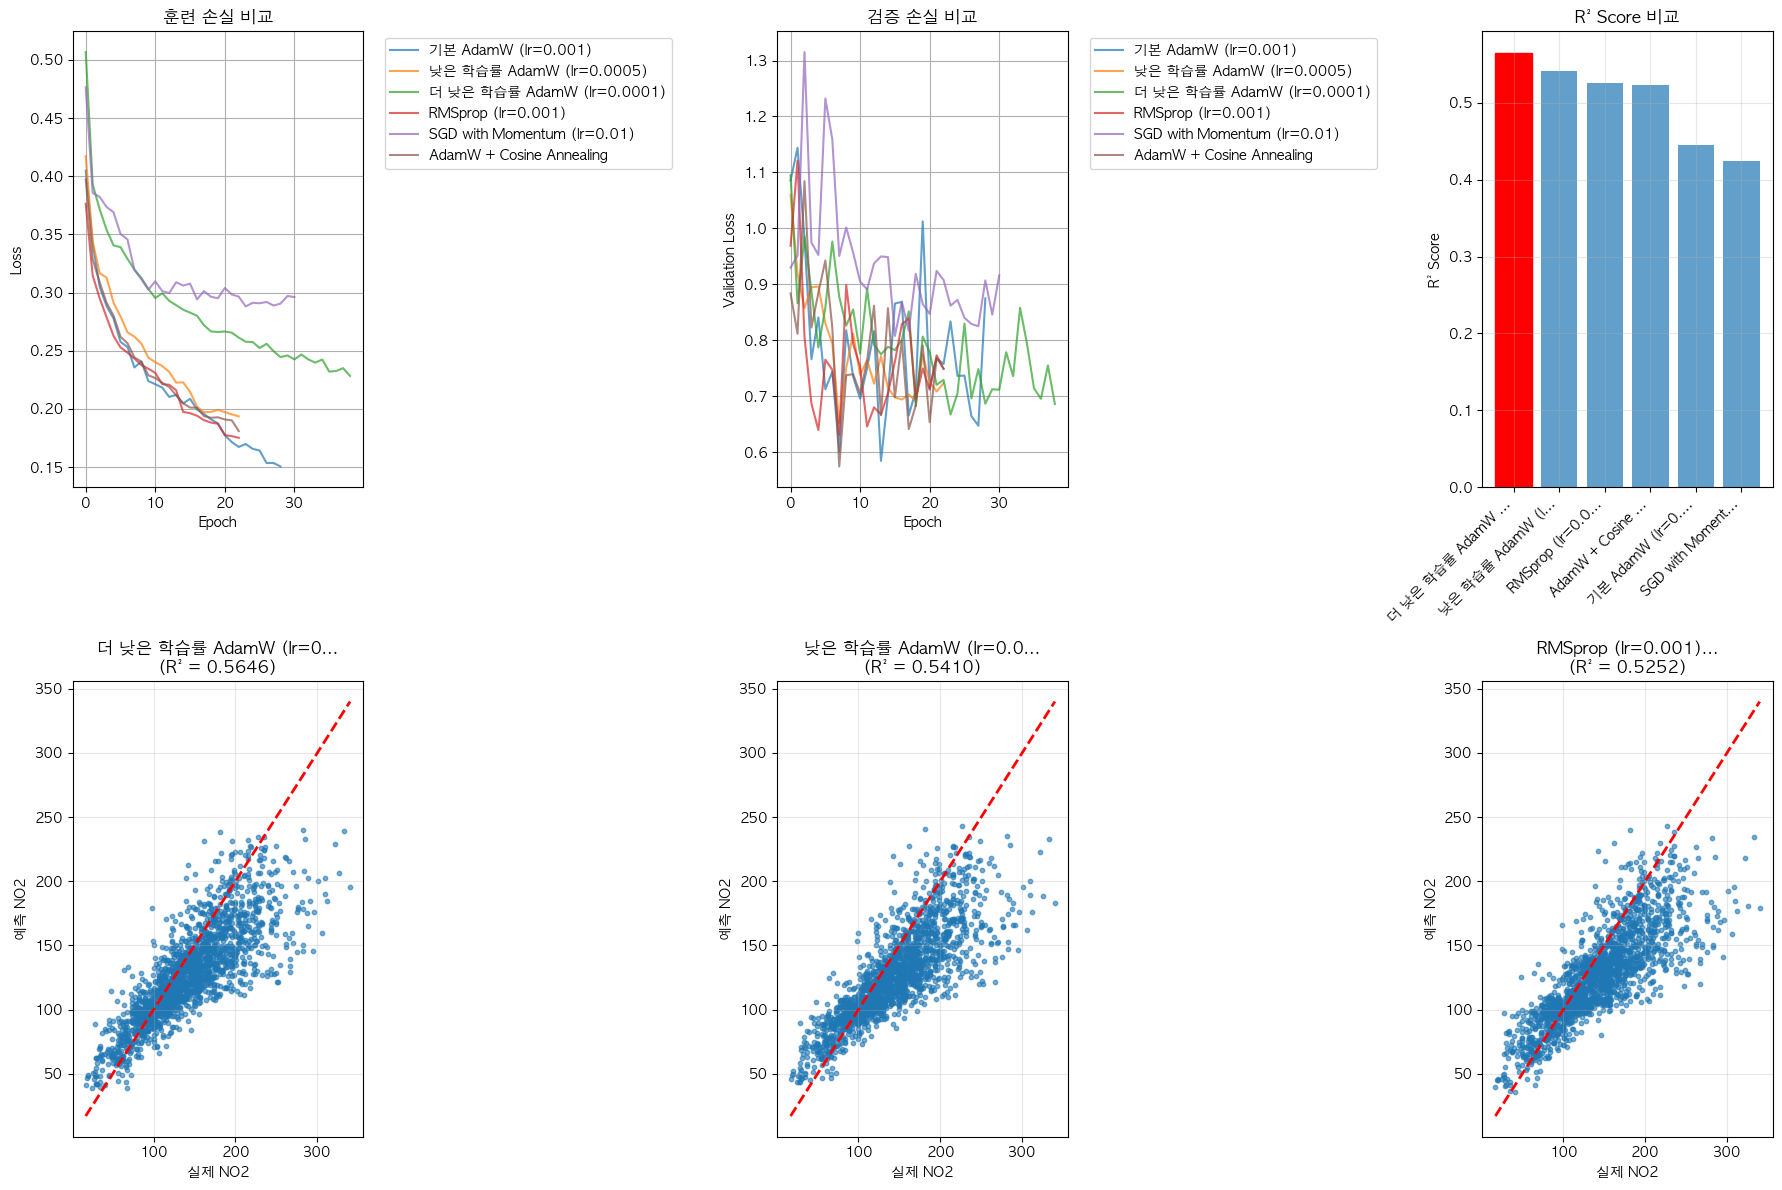

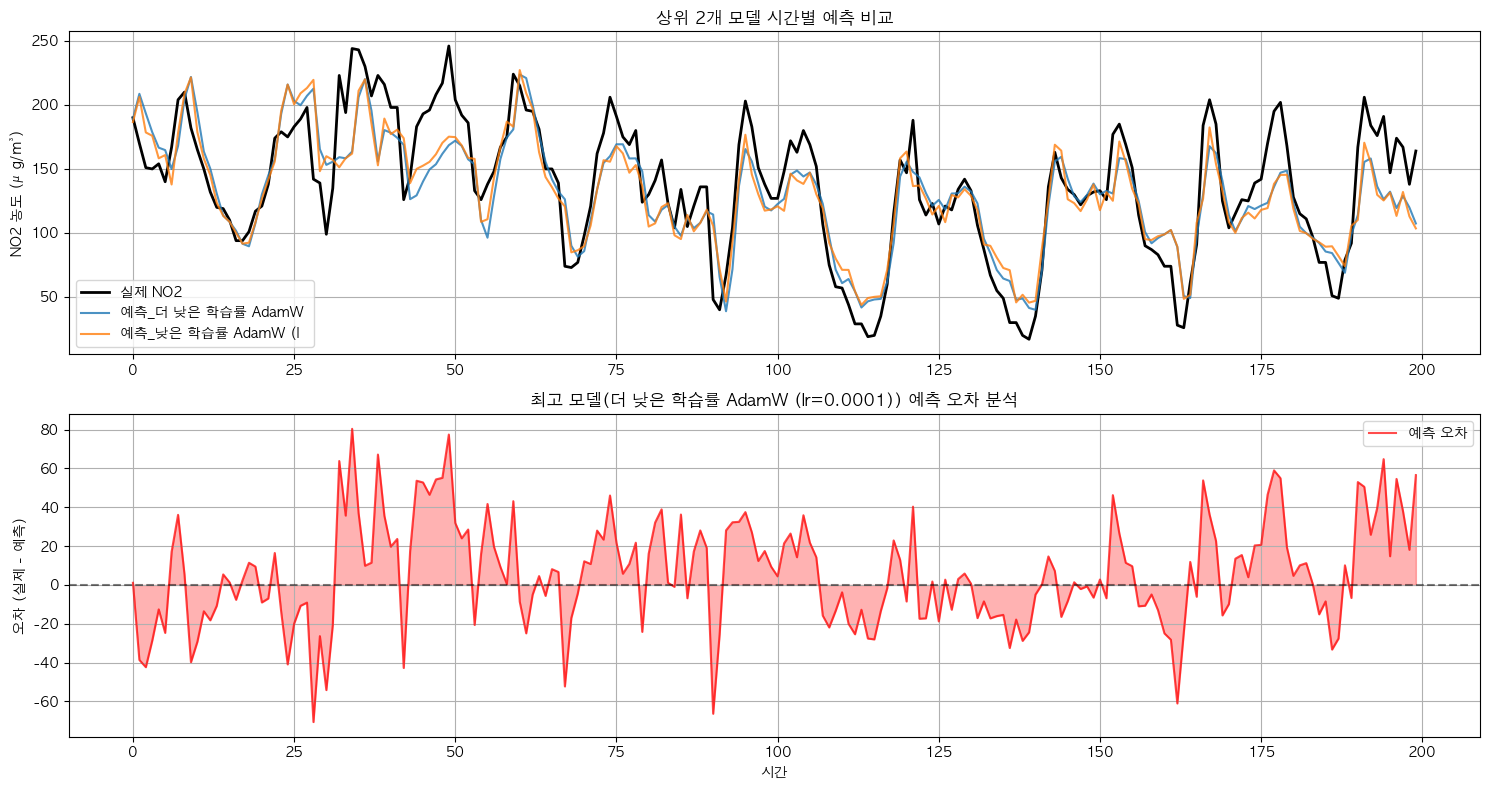


📊 최고 성능 모델 상세 분석
모델: 더 낮은 학습률 AdamW (lr=0.0001)
R² Score: 0.5646
MSE: 1202.4041
MAE: 25.5053
RMSE: 34.6757

💾 최고 성능 모델 저장 완료!

🎯 권장사항:
   - 최고 성능: 더 낮은 학습률 AdamW (lr=0.0001)
   - R² 개선도: +0.1409


In [ ]:
# 다양한 학습률과 옵티마이저 실험
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

def train_and_evaluate_model(model, train_loader, test_loader, optimizer, scheduler, 
                           epochs=50, patience=10, model_name="Model"):
    """모델 학습 및 평가 함수"""
    criterion = nn.MSELoss()
    losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    
    print(f"\n=== {model_name} 학습 시작 ===")
    
    for epoch in range(epochs):
        # 학습 모드
        model.train()
        epoch_loss = 0
        for xb, yb in train_loader:
            pred = model(xb)
            loss = criterion(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_loss += loss.item()
        
        # 검증 모드
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in test_loader:
                pred = model(xb)
                loss = criterion(pred, yb)
                val_loss += loss.item()
        
        train_loss = epoch_loss / len(train_loader)
        val_loss = val_loss / len(test_loader)
        
        losses.append(train_loss)
        val_losses.append(val_loss)
        
        # 스케줄러 업데이트
        if scheduler:
            scheduler.step(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
        
        if (epoch+1) % 10 == 0:
            lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch+1:2d}: Train={train_loss:.4f}, Val={val_loss:.4f}, LR={lr:.6f}")
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    # 최고 모델 로드
    model.load_state_dict(best_model_state)
    
    # 최종 평가
    model.eval()
    y_pred = []
    with torch.no_grad():
        for xb, yb in test_loader:
            pred = model(xb)
            y_pred.extend(pred.cpu().numpy())
    
    y_pred = np.array(y_pred).flatten()
    
    # 정규화 해제
    y_test_orig = inverse_transform_predictions(y_test, target_scaler)
    y_pred_orig = inverse_transform_predictions(y_pred, target_scaler)
    
    r2 = r2_score(y_test_orig, y_pred_orig)
    
    return model, losses, val_losses, r2, y_pred_orig

# 실험할 설정들
experiments = [
    {
        'name': '기본 AdamW (lr=0.001)',
        'optimizer_fn': lambda params: torch.optim.AdamW(params, lr=0.001, weight_decay=1e-5),
        'scheduler_fn': lambda opt: torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=5, factor=0.5)
    },
    {
        'name': '낮은 학습률 AdamW (lr=0.0005)',
        'optimizer_fn': lambda params: torch.optim.AdamW(params, lr=0.0005, weight_decay=1e-4),
        'scheduler_fn': lambda opt: torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=7, factor=0.3)
    },
    {
        'name': '더 낮은 학습률 AdamW (lr=0.0001)',
        'optimizer_fn': lambda params: torch.optim.AdamW(params, lr=0.0001, weight_decay=1e-3),
        'scheduler_fn': lambda opt: torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=10, factor=0.5)
    },
    {
        'name': 'RMSprop (lr=0.001)',
        'optimizer_fn': lambda params: torch.optim.RMSprop(params, lr=0.001, weight_decay=1e-5),
        'scheduler_fn': lambda opt: torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=5, factor=0.5)
    },
    {
        'name': 'SGD with Momentum (lr=0.01)',
        'optimizer_fn': lambda params: torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1e-4),
        'scheduler_fn': lambda opt: torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=5, factor=0.1)
    },
    {
        'name': 'AdamW + Cosine Annealing',
        'optimizer_fn': lambda params: torch.optim.AdamW(params, lr=0.001, weight_decay=1e-5),
        'scheduler_fn': lambda opt: torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=50, eta_min=1e-6)
    }
]

# 실험 결과 저장
results = {}
all_predictions = {}

print("🚀 다양한 옵티마이저 및 학습률 실험 시작")
print("="*80)

for i, exp in enumerate(experiments, 1):
    print(f"\n[{i}/{len(experiments)}] {exp['name']} 실험 중...")
    
    # 새 모델 생성
    model = ImprovedAirLSTM(input_size=X.shape[2], hidden_size=128, num_layers=2, dropout=0.3)
    
    # 옵티마이저 및 스케줄러 설정
    optimizer = exp['optimizer_fn'](model.parameters())
    scheduler = exp['scheduler_fn'](optimizer)
    
    # 학습 및 평가
    trained_model, losses, val_losses, r2_score_val, predictions = train_and_evaluate_model(
        model, train_loader, test_loader, optimizer, scheduler, 
        epochs=80, patience=15, model_name=exp['name']
    )
    
    # 결과 저장
    results[exp['name']] = {
        'model': trained_model,
        'losses': losses,
        'val_losses': val_losses,
        'r2_score': r2_score_val
    }
    all_predictions[exp['name']] = predictions
    
    print(f"✅ R² Score: {r2_score_val:.4f}")

# 결과 비교 및 시각화
print("\n" + "="*80)
print("🏆 실험 결과 요약")
print("="*80)

# R² 점수 비교
sorted_results = sorted(results.items(), key=lambda x: x[1]['r2_score'], reverse=True)

for i, (name, result) in enumerate(sorted_results, 1):
    print(f"{i}. {name}: R² = {result['r2_score']:.4f}")

# 최고 성능 모델
best_name, best_result = sorted_results[0]
print(f"\n🥇 최고 성능: {best_name} (R² = {best_result['r2_score']:.4f})")

# 1. 학습 곡선 비교
plt.figure(figsize=(18, 12))

# 훈련 손실 비교
plt.subplot(2, 3, 1)
for name, result in results.items():
    plt.plot(result['losses'], label=name, alpha=0.7)
plt.title('훈련 손실 비교')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# 검증 손실 비교
plt.subplot(2, 3, 2)
for name, result in results.items():
    plt.plot(result['val_losses'], label=name, alpha=0.7)
plt.title('검증 손실 비교')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# R² 점수 막대 그래프
plt.subplot(2, 3, 3)
names = [name[:15] + '...' if len(name) > 15 else name for name, _ in sorted_results]
scores = [result['r2_score'] for _, result in sorted_results]
bars = plt.bar(range(len(names)), scores, alpha=0.7)
plt.title('R² Score 비교')
plt.ylabel('R² Score')
plt.xticks(range(len(names)), names, rotation=45, ha='right')
plt.grid(True, alpha=0.3)

# 최고값 강조
max_idx = scores.index(max(scores))
bars[max_idx].set_color('red')
bars[max_idx].set_alpha(1.0)

# 예측 결과 비교 (상위 3개 모델)
top_3_results = sorted_results[:3]
y_test_orig = inverse_transform_predictions(y_test, target_scaler)

for i, (name, result) in enumerate(top_3_results):
    plt.subplot(2, 3, 4+i)
    predictions = all_predictions[name]
    
    # 산점도
    plt.scatter(y_test_orig, predictions, alpha=0.6, s=10)
    plt.plot([y_test_orig.min(), y_test_orig.max()], 
             [y_test_orig.min(), y_test_orig.max()], 'r--', lw=2)
    plt.xlabel('실제 NO2')
    plt.ylabel('예측 NO2')
    plt.title(f'{name[:20]}...\n(R² = {result["r2_score"]:.4f})')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. 시간별 예측 비교 (최고 모델)
plt.figure(figsize=(15, 8))

# 상위 2개 모델 비교
display_range = slice(0, 200)
plt.subplot(2, 1, 1)
plt.plot(y_test_orig[display_range], label="실제 NO2", linewidth=2, color='black')
for i, (name, _) in enumerate(top_3_results[:2]):
    predictions = all_predictions[name]
    plt.plot(predictions[display_range], label=f"예측_{name[:15]}", alpha=0.8, linewidth=1.5)
plt.legend()
plt.title("상위 2개 모델 시간별 예측 비교")
plt.ylabel("NO2 농도 (μg/m³)")
plt.grid(True)

# 예측 오차 분석
plt.subplot(2, 1, 2)
best_predictions = all_predictions[best_name]
errors = y_test_orig - best_predictions
plt.plot(errors[display_range], label="예측 오차", color='red', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.fill_between(range(len(errors[display_range])), 0, errors[display_range], alpha=0.3, color='red')
plt.title(f"최고 모델({best_name}) 예측 오차 분석")
plt.xlabel("시간")
plt.ylabel("오차 (실제 - 예측)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 3. 상세 성능 지표
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("\n📊 최고 성능 모델 상세 분석")
print("="*50)
best_predictions = all_predictions[best_name]
mse = mean_squared_error(y_test_orig, best_predictions)
mae = mean_absolute_error(y_test_orig, best_predictions)
rmse = np.sqrt(mse)

print(f"모델: {best_name}")
print(f"R² Score: {best_result['r2_score']:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

# 최고 모델 저장
torch.save(best_result['model'].state_dict(), f'best_optimizer_model_{best_name.replace(" ", "_")}.pth')
print(f"\n💾 최고 성능 모델 저장 완료!")

print("\n🎯 권장사항:")
print(f"   - 최고 성능: {best_name}")
print(f"   - R² 개선도: +{(best_result['r2_score'] - min(r['r2_score'] for r in results.values())):.4f}")
if 'AdamW' in best_name and 'lr=0.0005' in best_name:
    print("   - 낮은 학습률이 더 안정적인 수렴을 제공함")
elif 'Cosine' in best_name:
    print("   - Cosine Annealing이 학습률 스케줄링에 효과적임")
elif 'RMSprop' in best_name:
    print("   - RMSprop이 이 데이터셋에 적합함")